<a id="title_ID"></a>
# Beginner: Read and Plot A TESS Light Curve File

This notebook tutorial demonstrates how to load and plot the contents of a TESS light curve (lc) file.  We will plot the flux timeseries contained within the file, and display which pixels were used in the photometric aperture.

In [101]:
%matplotlib inline
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
try:
  from astroquery.mast import Tesscut, Observations, Catalogs
  from uncertainties.umath import *
  from uncertainties import ufloat
except:
  !pip install astroquery uncertainties
  from astroquery.mast import Tesscut, Observations, Catalogs
  from uncertainties.umath import *
  from uncertainties import ufloat

     |████████████████████████████████| 235kB 4.7MB/s 
  Created wheel for uncertainties: filename=uncertainties-3.1.2-cp36-none-any.whl size=96455 sha256=34db262b479f5e5a975d3279bb2c032979d0b1995f52100504e394759317ba16
  Stored in directory: /root/.cache/pip/wheels/d9/d3/0e/5b0b743a8abd50373705427438456da5dc2621891138d7a618
Successfully built uncertainties


## Introduction

A light curve is a plot of flux versus time, and is used to identify variability, including the transits of orbiting companions like planets.  The light curve shown here will be for the star TIC 25155310, which is known to host at least one planet, WASP-126 b.

This tutorial will refer to a couple TESS-related terms that we define here.
* Sector = TESS observed the sky in regions of 24x96 degrees along the southern, then northern, ecliptic hemispheres.  Each of these regions is referred to as a "sector", starting with Sector 1.
* HDU = Header Data Unit.  A FITS file is made up of HDUs that contain data and metadata relating to the file. The first HDU is called the primary HDU, and anything that follows is considered an "extension", e.g., "the first FITS extension", "the second FITS extension", etc.
* BJD = Barycentric Julian Date, the Julian Date that has been corrected for differences in the Earth's position with respect to the Solar System center of mass.
* TBJD = TESS Barycentric Julian Date, the timestamp measured in BJD, but offset by 2457000.0.  I.e., TBJD = BJD - 2457000.0
* SAP Flux = Simple Aperture Photometry flux, the flux after summing the calibrated pixels within the TESS optimal photometric aperture.
* PDCSAP Flux = Pre-search Data Conditioned Simple Aperture Photometry, the SAP flux values nominally corrected for instrumental variations.  Thus, these fluxes are the mission's best estimate of the intrinsic variability of the target.

### **Give star name here:**

In [0]:
target_name = 'XZ Dra'

In [0]:
# Query the TESS Input Catalog
catalogTIC = Catalogs.query_object(target_name, radius=0.1, catalog="TIC")

where_closest = np.round(catalogTIC['dstArcSec'],1) == 0

tic_id = catalogTIC['ID'][where_closest][0]

tasoc_res = Observations.query_criteria(target_name=tic_id, 
                                        obs_collection="TESS", 
                                        project="TESS")

In [0]:
def fluxtomag(mag):
    return -2.5*log(mag)/log(10)+20.62

Sector  14
INFO: Found cached file ./mastDownload/TESS/tess2019198215352-s0014-0000000229913521-0150-s/tess2019198215352-s0014-0000000229913521-0150-s_lc.fits with expected size 1964160. [astroquery.query]
Sector  15
INFO: Found cached file ./mastDownload/TESS/tess2019226182529-s0015-0000000229913521-0151-s/tess2019226182529-s0015-0000000229913521-0151-s_lc.fits with expected size 1906560. [astroquery.query]


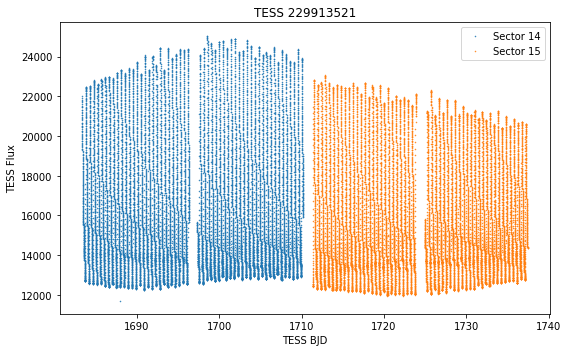

In [126]:
fig = plt.figure(figsize=(8,5))

for sector in tasoc_res['sequence_number']:
  print("Sector ",sector)
  
  tasoc_prod = Observations.get_product_list(tasoc_res[ tasoc_res['sequence_number']==sector ])
  
  tasoc_manifest = Observations.download_products(tasoc_prod[ tasoc_prod["description"]=="Light curves" ])
  
  fits_file = tasoc_manifest["Local Path"][0]
  
  with fits.open(fits_file, mode="readonly") as hdulist:
    tess_bjds = hdulist[1].data['TIME']
    sap_fluxes = hdulist[1].data['SAP_FLUX']
    sap_flux_err = hdulist[1].data['SAP_FLUX_ERR']
    pdcsap_fluxes = hdulist[1].data['PDCSAP_FLUX']
    pdcsap_flux_err = hdulist[1].data['PDCSAP_FLUX_ERR']
    qual_flags = hdulist[1].data['QUALITY']
    
    
  np.savetxt('TIC_%d_TESS_s%d_sc.dat' % (int(tic_id),sector), \
             np.c_[tess_bjds,sap_fluxes,sap_flux_err,pdcsap_fluxes,pdcsap_flux_err,qual_flags], \
             fmt='%.8f %.4f %.4f %.4f %.4f %d',\
    header='BJD-2457000 SAP_FLUX SAP_FLUX_ERR PDCSAP_FLUX PDCSAP_FLUX_ERR QUALITY')
  
  pdcsapmag = []
  sapmag = []
  pdcsapmagerr = []
  sapmagerr = []

  for i in range(len(tess_bjds)):
      point = ufloat(sap_fluxes[i],sap_flux_err[i])
      mag = fluxtomag(point)
      sapmag.append(mag.n)
      sapmagerr.append(mag.s)
      point = ufloat(pdcsap_fluxes[i],pdcsap_flux_err[i])
      mag = fluxtomag(point)
      pdcsapmag.append(mag.n)
      pdcsapmagerr.append(mag.s)
      
  pdcsapmag = np.array(pdcsapmag)
  sapmag = np.array(sapmag)
  pdcsapmagerr = np.array(pdcsapmagerr)
  sapmagerr = np.array(sapmagerr)
  
  np.savetxt('TIC_%d_TESS_s%d_sc_in_mag.dat' % (int(tic_id),sector),\
             np.c_[tess_bjds,sapmag,sapmagerr,pdcsapmag,pdcsapmagerr,qual_flags],\
             fmt='%.8f %.4f %.4f %.4f %.4f %d',\
    header='BJD-2457000 SAP_MAG SAP_MAG_ERR PDCSAP_MAG PDCSAP_MAG_ERR QUALITY')
    
  plt.plot(tess_bjds,sap_fluxes,'.',ms=1.,label="Sector %d" % sector)
  
plt.title('TESS %d' % int(tic_id))
plt.xlabel('TESS BJD')
plt.ylabel('TESS Flux')
plt.legend()
plt.tight_layout()
plt.savefig('TIC_%d_TESS_sc.pdf' % int(tic_id), format='pdf',dpi=50)
plt.show()